In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 20
n_levels = 1000

In [3]:
d = pandas.DataFrame({"y":numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.normal(size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_10,noise_11,noise_12,noise_13,noise_14,noise_15,noise_16,noise_17,noise_18,noise_19
0,-1.512479,level_62,level_622,level_687,level_818,level_99,level_270,level_223,level_108,level_812,...,level_964,level_462,level_17,level_249,level_633,level_502,level_874,level_98,level_788,level_379
1,-1.275709,level_219,level_882,level_894,level_137,level_192,level_775,level_808,level_196,level_716,...,level_112,level_126,level_72,level_315,level_492,level_857,level_887,level_16,level_129,level_845
2,-2.053840,level_557,level_394,level_236,level_451,level_629,level_939,level_287,level_799,level_162,...,level_6,level_749,level_156,level_182,level_773,level_34,level_474,level_369,level_72,level_38
3,-3.870142,level_983,level_469,level_644,level_896,level_4,level_553,level_193,level_231,level_700,...,level_930,level_206,level_8,level_655,level_535,level_145,level_163,level_253,level_76,level_874
4,-1.878621,level_733,level_347,level_563,level_895,level_560,level_306,level_717,level_816,level_297,...,level_10,level_668,level_752,level_341,level_875,level_720,level_722,level_500,level_217,level_205


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_10_impact_code,noise_11_impact_code,noise_12_impact_code,noise_13_impact_code,noise_14_impact_code,noise_15_impact_code,noise_16_impact_code,noise_17_impact_code,noise_18_impact_code,noise_19_impact_code
0,-2.381684,-2.104251,-4.765004,-0.252371,3.598255,0.099845,-2.034106,-0.899741,-0.038524,1.763707,...,1.612743,-0.901466,0.485914,-0.049948,-0.912003,-0.202120,0.898147,-1.536223,-0.747063,-2.543203
1,-1.399175,-1.939733,-0.698308,0.194228,-2.077583,0.170268,-1.196393,0.564307,-2.077583,-0.309568,...,0.403824,-1.389051,0.130655,1.388417,-0.508354,-1.144589,-1.754423,-1.589817,0.388164,-2.146584
2,-1.417156,-1.514796,-3.893886,-0.249653,-3.624847,-2.176076,-0.317911,0.503130,-0.435899,-2.439520,...,-3.893886,0.101694,-1.479740,-1.491016,-3.893886,-2.031196,0.188012,-3.893886,-2.144517,-3.893886
3,-0.858530,-1.974885,-2.999218,-1.902365,1.375042,-1.590862,-1.588066,-0.357176,-4.601834,1.458501,...,-2.788086,1.160561,1.155715,-0.138130,-1.902365,-0.110150,0.338963,-0.250018,1.715388,0.415228
4,-2.035177,-3.035073,-1.998686,-0.757349,-1.416043,-2.952257,-2.649014,-1.626104,-3.189519,-2.952257,...,1.488838,-0.586472,-2.592636,-4.707346,-3.194351,-2.584087,-3.494238,-2.952257,-2.290325,-2.240008


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_10_impact_code,noise_11_impact_code,noise_12_impact_code,noise_13_impact_code,noise_14_impact_code,noise_15_impact_code,noise_16_impact_code,noise_17_impact_code,noise_18_impact_code,noise_19_impact_code
0,-1.909948,-0.947676,-3.326575e+00,-2.262960e-01,1.253636e+00,5.112139e-02,-1.972252,-0.811711,-0.028256,0.589089,...,9.921386e-01,-0.440438,0.414720,-0.025565,-8.881952e-01,-0.143835,0.465830,0.000000,-0.604520,-1.863388
1,-1.252605,-1.894818,-5.684474e-01,1.535153e-01,-3.469447e-18,1.223043e-01,-0.903133,0.404011,0.000000,-0.213788,...,1.557779e-01,-0.903957,0.046638,0.745954,-2.732874e-01,-0.910694,-1.595830,-1.333192,0.294616,-1.140305
2,-0.774806,-0.534919,-3.469447e-18,-7.342844e-02,-2.253121e+00,-9.787758e-01,-0.061632,0.213264,-0.136761,-1.690215,...,3.469447e-18,0.015921,-1.235856,-0.670184,-3.469447e-18,-1.901039,0.084539,0.000000,-1.381208,0.000000
3,-0.564615,-1.958810,-2.554432e+00,3.469447e-18,1.069939e+00,-1.537477e+00,-1.348056,-0.281568,-2.187472,0.815940,...,-1.631420e+00,0.728091,0.259439,-0.081337,-3.469447e-18,-0.098083,0.205748,-0.183591,1.163523,0.266100
4,-1.929813,-0.915852,-1.577363e+00,-1.982328e-01,-7.533978e-01,3.469447e-18,-2.571700,-1.406151,-3.128655,0.000000,...,4.852605e-01,-0.276976,-2.473991,-2.199724,-2.347868e+00,-2.208081,-2.851071,0.000000,-1.731833,-1.894122


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_10_impact_code,noise_11_impact_code,noise_12_impact_code,noise_13_impact_code,noise_14_impact_code,noise_15_impact_code,noise_16_impact_code,noise_17_impact_code,noise_18_impact_code,noise_19_impact_code
0,0.000000,-4.410653e-01,-3.802091e+00,3.785141e-01,0.000000e+00,1.734723e-18,-2.618627,-4.462575e-01,2.253484e-01,0.000000e+00,...,-1.734723e-18,-0.127851,1.041374e+00,0.165078,-0.587222,-0.261306,4.885900e-01,0.000000,1.734723e-18,0.000000
1,-0.379997,-1.797717e+00,-3.187352e-01,3.050309e-01,0.000000e+00,1.734723e-18,0.222960,1.734723e-18,0.000000e+00,1.700485e-01,...,-2.151714e+00,0.109171,-1.734723e-18,0.000000,0.000000,0.448745,1.734723e-18,-0.826536,5.321886e-01,-0.256076
2,0.000000,-8.673617e-19,0.000000e+00,-8.673617e-19,-1.895280e+00,0.000000e+00,0.000000,1.943479e+00,2.284351e-01,-8.673617e-19,...,0.000000e+00,0.000000,0.000000e+00,-0.220404,0.000000,-1.695084,1.896790e+00,0.000000,-8.673617e-19,0.000000
3,-0.344378,0.000000e+00,-2.578087e+00,0.000000e+00,1.765915e+00,0.000000e+00,0.000000,-1.193337e-01,3.469447e-18,2.831001e+00,...,-1.273807e+00,2.738213,0.000000e+00,-0.597742,0.000000,0.358807,-3.469447e-18,0.229794,1.686652e+00,0.608921
4,-1.592341,-3.407191e-01,-6.938894e-18,0.000000e+00,6.938894e-18,0.000000e+00,0.000000,-1.828641e+00,0.000000e+00,0.000000e+00,...,1.025920e+00,0.158180,0.000000e+00,0.000000,-2.087549,-1.452941,0.000000e+00,0.000000,-9.940506e-01,0.000000


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.644788,0.544526,0.092948,0.124266,False
1,var_1_impact_code,0.661523,0.563951,0.131639,0.088187,False
2,var_2_impact_code,0.649108,0.552370,0.090711,0.107474,False
3,var_3_impact_code,0.661329,0.563282,0.113515,0.133576,False
4,var_4_impact_code,0.642346,0.565297,0.097320,0.093026,False
5,var_5_impact_code,0.626977,0.530813,0.119348,0.095392,False
6,var_6_impact_code,0.660658,0.559396,0.134944,0.096875,False
7,var_7_impact_code,0.642193,0.541202,0.084799,0.098976,False
8,var_8_impact_code,0.659190,0.575860,0.136418,0.117148,False
9,var_9_impact_code,0.634396,0.536409,0.054540,0.115450,False


(0.8586098467356158, 1.2887439554616704e-09)


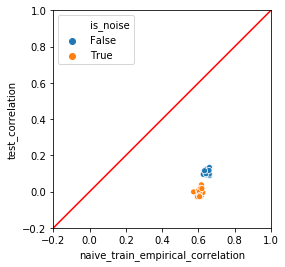

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8578727344570392, 1.3794662871152999e-09)


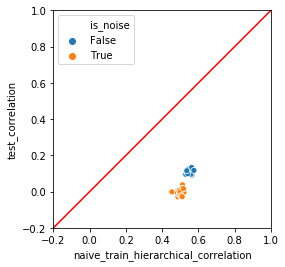

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8835126008896232, 1.0040423087447391e-10)


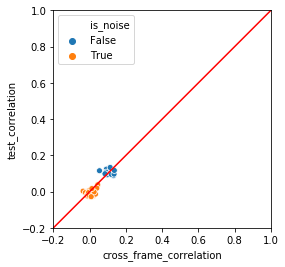

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
25,noise_15_impact_code,impact_code,True,True,-0.005396,0.786317,30.0,False
26,noise_16_impact_code,impact_code,True,True,0.024809,0.212503,30.0,False
27,noise_17_impact_code,impact_code,True,True,-0.002311,0.907565,30.0,False
28,noise_18_impact_code,impact_code,True,True,0.008704,0.661875,30.0,False
29,noise_19_impact_code,impact_code,True,True,0.012430,0.532271,30.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_1_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-1.275709,-0.571424,-0.625263,-0.344465,-0.834632
1,3.229611,0.851995,0.922912,0.627789,1.143239
2,-1.110627,-1.454640,-1.529919,-0.545726,-0.741694
3,-3.574484,-0.030518,0.066862,-0.467567,-0.760004
4,5.308181,1.446994,1.590186,0.428473,0.726234


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

0.7140043412841672


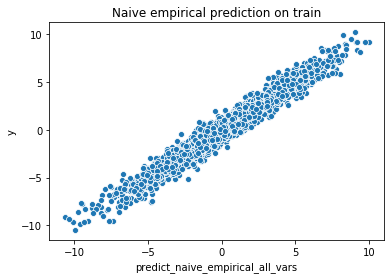

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

1.1472072730966285


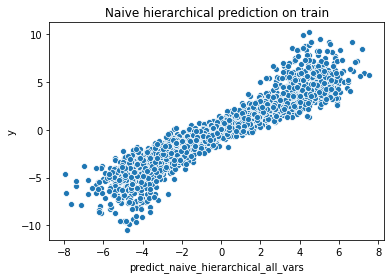

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

3.0988752035926592


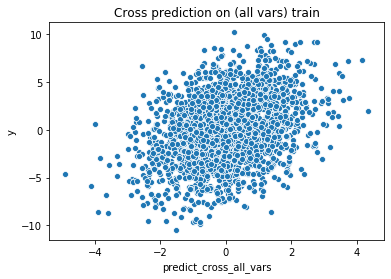

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

3.1081115173514657


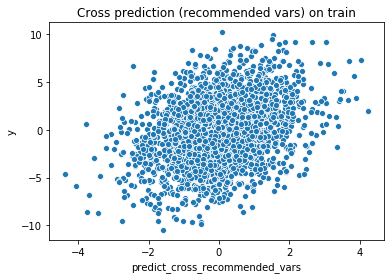

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

3.2394949260318953


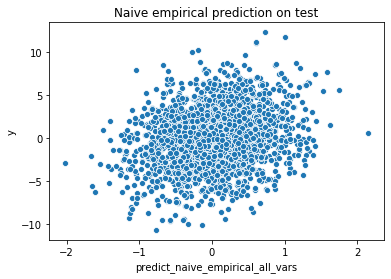

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

3.22983740774229


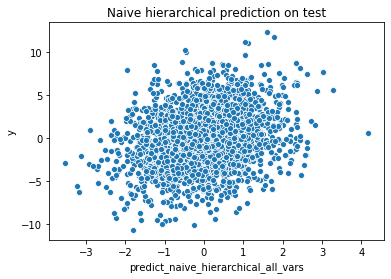

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

3.1421760904178466


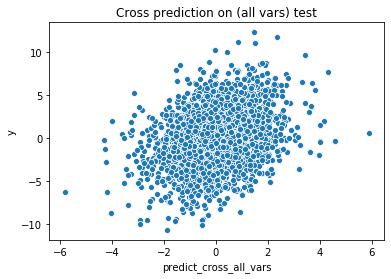

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

3.132116151044606


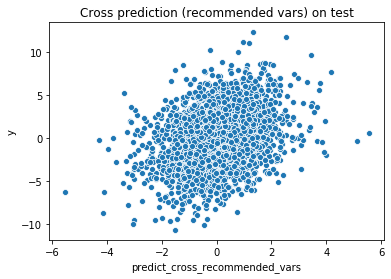

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     1701.
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:49:06   Log-Likelihood:                -2734.4
No. Observations:                2527   AIC:                             5531.
Df Residuals:                    2496   BIC:                             5712.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0237      0.014      1.661      0.097      -0.004       0.052
var_0_impact_code        0.0780      0.009      8.956      0.000       0.061       0.095
var_1_impact_code        0.1058      0.009     12.393      0.000       0.089       0.123
var_2_impact_code        0.0905      0.009     10.485      0.000       0.074       0.107
var_3_impact_code        0.0890      0.009     10.359      0.000       0.072       0.106
var_4_impact_code        0.0903      0.009     10.443      0.000       0.073       0.107
var_5_impact_code        0.0792      0.009      9.049      0.000       0.062       0.096
var_6_impact_code        0.0882      0.009     10.240      0.000       0.071       0.105
var_7_impact_code        0.0899      0.009     10.400      0.000       0.073       0.107
var_8_impact_code        0.1038      0.009     12.156      0.000       0.087       0.121
var_9_impact_code        0.0912      0.009     10.489      0.000       0.074       0.108
noise_0_impact_code      0.0829      0.009      9.346      0.000       0.065       0.100
noise_1_impact_code      0.0882      0.009     10.003      0.000       0.071       0.105
noise_2_impact_code      0.0734      0.009      8.298      0.000       0.056       0.091
noise_3_impact_code      0.0834      0.009      9.419      0.000       0.066       0.101
noise_4_impact_code      0.0526      0.009      5.817      0.000       0.035       0.070
noise_5_impact_code      0.0821      0.009      9.209      0.000       0.065       0.100
noise_6_impact_code      0.0830      0.009      9.355      0.000       0.066       0.100
noise_7_impact_code      0.0710      0.009      7.752      0.000       0.053       0.089
noise_8_impact_code      0.0556      0.009      6.222      0.000       0.038       0.073
noise_9_impact_code      0.0768      0.009      8.686      0.000       0.059       0.094
noise_10_impact_code     0.0727      0.009      8.160      0.000       0.055       0.090
noise_11_impact_code     0.0825      0.009      9.335      0.000       0.065       0.100
noise_12_impact_code     0.0909      0.009     10.223      0.000       0.073       0.108
noise_13_impact_code     0.0896      0.009     10.175      0.000       0.072       0.107
noise_14_impact_code     0.0830      0.009      9.443      0.000       0.066       0.100
noise_15_impact_code     0.0673      0.009      7.643      0.000       0.050       0.085
noise_16_impact_code     0.0683      0.009      7.634      0.000       0.051       0.086
noise_17_impact_code     0.0703      0.009      7.900      0.000       0.053       0.088
noise_18_impact_code     0.0802      0.009      9.021      0.000       0.063       0.098
noise_19_impact_code     0.0910      0.009     10.396      0.000       0.074       0.108
=========================================================

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9533556878472528

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.04402895774168669

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     11.49
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           3.36e-51
Time:                        15:49:06   Log-Likelihood:                -6443.8
No. Observations:                2527   AIC:                         1.295e+04
Df Residuals:                    2496   BIC:                         1.313e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0087      0.062      0.139      0.889      -0.114       0.131
var_0_impact_code        0.2479      0.057      4.328      0.000       0.136       0.360
var_1_impact_code        0.3416      0.052      6.537      0.000       0.239       0.444
var_2_impact_code        0.2574      0.056      4.636      0.000       0.149       0.366
var_3_impact_code        0.3248      0.052      6.232      0.000       0.223       0.427
var_4_impact_code        0.3262      0.056      5.850      0.000       0.217       0.436
var_5_impact_code        0.3327      0.058      5.735      0.000       0.219       0.446
var_6_impact_code        0.3398      0.051      6.706      0.000       0.240       0.439
var_7_impact_code        0.2294      0.057      4.040      0.000       0.118       0.341
var_8_impact_code        0.3869      0.055      6.982      0.000       0.278       0.496
var_9_impact_code        0.1673      0.055      3.041      0.002       0.059       0.275
noise_0_impact_code      0.0292      0.060      0.489      0.625      -0.088       0.147
noise_1_impact_code      0.1455      0.059      2.479      0.013       0.030       0.261
noise_2_impact_code     -0.0128      0.059     -0.217      0.829      -0.129       0.103
noise_3_impact_code      0.0399      0.060      0.661      0.509      -0.079       0.158
noise_4_impact_code      0.0190      0.059      0.321      0.748      -0.097       0.135
noise_5_impact_code     -0.0021      0.059     -0.035      0.972      -0.117       0.113
noise_6_impact_code      0.0942      0.059      1.595      0.111      -0.022       0.210
noise_7_impact_code     -0.0429      0.062     -0.692      0.489      -0.164       0.079
noise_8_impact_code     -0.0312      0.059     -0.528      0.597      -0.147       0.085
noise_9_impact_code     -0.0973      0.063     -1.548      0.122      -0.220       0.026
noise_10_impact_code    -0.0740      0.061     -1.212      0.226      -0.194       0.046
noise_11_impact_code    -0.0606      0.063     -0.959      0.338      -0.185       0.063
noise_12_impact_code    -0.0123      0.058     -0.213      0.831      -0.126       0.101
noise_13_impact_code     0.1073      0.059      1.823      0.068      -0.008       0.223
noise_14_impact_code    -0.0154      0.057     -0.268      0.788      -0.128       0.097
noise_15_impact_code    -0.0128      0.061     -0.209      0.835      -0.133       0.108
noise_16_impact_code     0.0798      0.060      1.326      0.185      -0.038       0.198
noise_17_impact_code     0.0146      0.060      0.246      0.806      -0.102       0.131
noise_18_impact_code     0.0140      0.059      0.237      0.813      -0.102       0.130
noise_19_impact_code     0.0472      0.057      0.832      0.405      -0.064       0.159
=========================================================

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.12137175133292588

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.10060355162051227

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     30.04
Date:                Thu, 25 Jul 2019   Prob (F-statistic):           4.20e-60
Time:                        15:49:06   Log-Likelihood:                -6451.3
No. Observations:                2527   AIC:                         1.293e+04
Df Residuals:                    2515   BIC:                         1.300e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0067      0.062      0.108      0.914      -0.115       0.129
var_0_impact_code       0.2554      0.057      4.476      0.000       0.143       0.367
var_1_impact_code       0.3397      0.052      6.528      0.000       0.238       0.442
var_2_impact_code       0.2548      0.055      4.612      0.000       0.146       0.363
var_3_impact_code       0.3229      0.052      6.226      0.000       0.221       0.425
var_4_impact_code       0.3239      0.055      5.844      0.000       0.215       0.433
var_5_impact_code       0.3335      0.058      5.775      0.000       0.220       0.447
var_6_impact_code       0.3403      0.050      6.744      0.000       0.241       0.439
var_7_impact_code       0.2368      0.057      4.188      0.000       0.126       0.348
var_8_impact_code       0.3952      0.055      7.172      0.000       0.287       0.503
var_9_impact_code       0.1638      0.055      2.997      0.003       0.057       0.271
noise_1_impact_code     0.1497      0.058      2.568      0.010       0.035       0.264
==============================================================================
Omnibus:                        1.857   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.859
Skew:                          -0.037   Prob(JB):                        0.395
Kurtosis:                       2.890   Cond. No.                         1.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.11612637705646545

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.10635331848351703